In [1]:
import tushare as ts
import seaborn as sns
import keras
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
from keras.models import Model
from keras import backend as K
from keras.layers import Input, Dense, LSTM, Dropout, Bidirectional, BatchNormalization, Activation
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import RMSprop, Adam
from keras.initializers import Orthogonal
from tcn import TCN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc, f1_score,
    confusion_matrix, recall_score, 
    precision_recall_fscore_support)
set_matplotlib_formats('retina')

Using TensorFlow backend.


In [2]:
use = ['Symbol', 'ContrshrProportion', 'IsRelatedTrading', 'ShareholderFirstProp',
       'ControlProportion', 'FamEntyp_1.0', 'FamEntyp_2.0', 'FamEntyp_3.0',
       'BoardCode_P3401', 'BoardCode_P3402', 'BoardCode_P3403', 'FamStyle_1',
       'FamStyle_2', 'ManGeneration_1.0', 'ManGeneration_2.0',
       'FamNameStatus_1', 'FamNameStatus_2', 'FamNameStatus_3',
       'FamNameStatus_4', 'FamNameStatus_5']
fam = pd.read_csv('../data/family_firm_clean.csv', index_col=0, usecols=use)

In [3]:
pledge_neg = pd.read_csv('../data/pledge/pledge_company_neg.csv', 
                         parse_dates=['start_date'])
pledge_pos = pd.read_csv('../data/pledge/pledge_company_pos.csv',
                        parse_dates=['start_date', 'close_date'])

In [4]:
pledge_neg = pledge_neg.sort_values(by=['start_date'])
pledge_neg = pledge_neg.reset_index(drop=True)

In [5]:
pledge_pos = pledge_pos.sort_values(by=['start_date'])
pledge_pos = pledge_pos.reset_index(drop=True)

In [6]:
pledge_pos.shape

(15891, 29)

In [7]:
pledge_neg.shape

(19753, 28)

In [8]:
pledge_neg = pledge_neg.merge(fam, how='left', left_on='ts_code', right_on='Symbol')
pledge_neg = pledge_neg.fillna(0)

In [9]:
pledge_pos = pledge_pos.merge(fam, how='left', left_on='ts_code', right_on='Symbol')
pledge_pos = pledge_pos.fillna(0)

In [10]:
pledge_neg.head(10)

,ts_code,start_date,pledge_price,forcast_close_line,current_ratio,quick_ratio,cash_ratio,inv_turn,ar_turn,ca_turn,...,BoardCode_P3403,FamStyle_1,FamStyle_2,ManGeneration_1.0,ManGeneration_2.0,FamNameStatus_1,FamNameStatus_2,FamNameStatus_3,FamNameStatus_4,FamNameStatus_5
0,600998.SH,2016-01-04,17.4032,12.18224,1.3862,1.0302,0.9365,1.7793,1.5325,0.5284,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
1,300071.SZ,2016-01-04,12.6686,8.86802,1.2334,1.2334,1.1324,0.0000,0.7313,0.5061,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
2,300409.SZ,2016-01-04,14.3533,10.04731,3.5132,2.8557,2.8079,0.2906,0.4558,0.1050,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
3,002706.SZ,2016-01-04,8.1208,5.68456,3.9828,3.4084,2.9236,0.9005,2.7326,0.2363,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
4,300203.SZ,2016-01-04,29.7155,20.80085,1.6633,1.3274,1.2020,0.2894,0.2386,0.1043,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
5,000603.SZ,2016-01-04,15.8926,11.12482,0.7487,0.6943,0.6544,0.7073,63.7869,0.1864,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
6,000401.SZ,2016-01-04,9.5732,6.70124,0.4462,0.3766,0.2715,0.9737,0.9353,0.1579,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,600189.SH,2016-01-04,8.8649,6.20543,0.8507,0.7656,0.5832,0.2099,1.4492,0.0485,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,000686.SZ,2016-01-04,14.1314,9.89198,1.4414,1.4414,0.0000,0.0000,0.0000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,002729.SZ,2016-01-05,62.5638,43.79466,8.5209,7.0754,4.3068,0.5076,1.0151,0.1381,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0


In [11]:
pledge_neg.shape

(19753, 47)

In [12]:
pledge_pos.shape

(15891, 48)

In [13]:
pledge_pos.columns

Index(['ts_code', 'start_date', 'pledge_price', 'forcast_close_line',
       'close_date', 'current_ratio', 'quick_ratio', 'cash_ratio', 'inv_turn',
       'ar_turn', 'ca_turn', 'netprofit_margin', 'grossprofit_margin', 'roe',
       'debt_to_assets', 'op_yoy', 'ebt_yoy', 'assets_yoy', 'tr_yoy', 'or_yoy',
       'q_gr_yoy', 'q_gr_qoq', 'q_sales_yoy', 'q_sales_qoq', 'q_op_yoy',
       'q_op_qoq', 'q_profit_yoy', 'q_profit_qoq', 'revenue',
       'ContrshrProportion', 'IsRelatedTrading', 'ShareholderFirstProp',
       'ControlProportion', 'FamEntyp_1.0', 'FamEntyp_2.0', 'FamEntyp_3.0',
       'BoardCode_P3401', 'BoardCode_P3402', 'BoardCode_P3403', 'FamStyle_1',
       'FamStyle_2', 'ManGeneration_1.0', 'ManGeneration_2.0',
       'FamNameStatus_1', 'FamNameStatus_2', 'FamNameStatus_3',
       'FamNameStatus_4', 'FamNameStatus_5'],
      dtype='object')

In [14]:
codes = set(pd.read_csv('../data/pledge/pledge_full_clean.csv')['ts_code'])
code_price_dict = dict()
for code in codes:
    price_df = pd.read_csv('../data/price/{}.csv'.format(code), index_col=0)
    price_df.index = pd.to_datetime(price_df.index)
    code_price_dict[code] = price_df

In [15]:
def get_stock_price_by_pos_code(code, lookback, 
                                delay, pledge_date, 
                                close_position_date, 
                                code_price_dict, forcast_close_line):
    """
    通过爆仓股票代码，过去天数，生成三维的股票价格矩阵
    delay * lookback * 9(features)
    """
#     scaler = MinMaxScaler()
    non_close_rate = 4
    step = 4
    price_df = code_price_dict[code]
    price_df = price_df.drop(['pre_close'], axis=1)
    price_df['delta'] = price_df.apply(lambda x: x['close'] - forcast_close_line, axis=1)
#     scaler.fit(price_df)
    price_df = price_df[pledge_date: close_position_date]
    price_values = price_df.values
    # 平仓训练集
    usable_close_len = len(price_df) - lookback
    usable_close_len = min(usable_close_len, delay + 1)
    close_list = []
    for i in range(1, usable_close_len + 1, step):
        price_time = price_values[-lookback - i: -i]
        close_list.append(price_time)
    # 正常训练集
    usable_non_close_len = len(price_df) - delay - lookback
    usable_non_close_len = min(usable_non_close_len, non_close_rate * delay)
    non_close_list = []
    for i in range(delay+1, delay+1+usable_non_close_len, step):
        price_time = price_values[-lookback - i: -i]
        non_close_list.append(price_time)
        
    return close_list, non_close_list

In [16]:
def get_stock_price_by_neg_code(code, delay, lookback, pledge_date, code_price_dict, forcast_close_line):
    """
    通过非爆仓股票代码，过去天数，生成三维的股票价格矩阵
    delay * lookback * 9(features)
    """
#     scaler = MinMaxScaler()
    step = 4
    price_df = code_price_dict[code]
    price_df = price_df.drop(['pre_close'], axis=1)
    price_df['delta'] = price_df.apply(lambda x: x['close'] - forcast_close_line, axis=1)
#     scaler.fit(price_df)
    price_df = price_df[:pledge_date]
    price_values = price_df.values
    # 质押前训练集
    usable_close_len = len(price_df) - lookback
    usable_close_len = min(usable_close_len, delay + 1)
    price_list = []
    for i in range(1, usable_close_len + 1, step):
        price_time = price_values[-lookback - i: -i]
        price_list.append(price_time)
        
    return price_list

In [17]:
def pos_generator(pledge, lookback, delay, min_index, max_index, code_price_dict):
    # batch_size == delay(30)
    i = min_index
    all_zip = []

    pledge_drop = pledge.drop(['ts_code', 'start_date', 'close_date'], axis=1)
    pledge_values = pledge_drop.values
    while i < max_index:
        single_pledge = pledge.loc[i]
        single_pledge_scaled = pledge_values[i]
        close_list, non_close_list = get_stock_price_by_pos_code(code=single_pledge['ts_code'],
                               lookback=lookback,
                               delay=delay,
                               pledge_date=single_pledge['start_date'],
                               close_position_date=single_pledge['close_date'],
                               code_price_dict=code_price_dict,
                               forcast_close_line=single_pledge['forcast_close_line'])
        close_zip = [(prices, single_pledge_scaled, 1) for prices in close_list]
        non_close_zip = [(prices, single_pledge_scaled, 0) for prices in non_close_list]
        all_zip += close_zip + non_close_zip
        i += 1
    return all_zip

In [18]:
def neg_generator(pledge, lookback, delay, min_index, max_index, code_price_dict):
    # batch_size == delay(30)
    i = min_index
    all_zip = []

    pledge_drop = pledge.drop(['ts_code', 'start_date'], axis=1)
    pledge_values = pledge_drop.values
    while i < max_index:
        single_pledge = pledge.loc[i]
        single_pledge_scaled = pledge_values[i]
        price_list = get_stock_price_by_neg_code(code=single_pledge['ts_code'],
                               lookback=lookback,
                               delay=delay,
                               pledge_date=single_pledge['start_date'],
                               code_price_dict=code_price_dict,
                               forcast_close_line=single_pledge['forcast_close_line'])
        all_zip += [(prices, single_pledge_scaled, 0) for prices in price_list]
        i += 1
    return all_zip

In [19]:
print('neg: {}  pos: {}'.format(len(pledge_neg), len(pledge_pos)))

neg: 19753  pos: 15891


In [20]:
lookback = 48
delay = 30
train_neg_num = int(len(pledge_neg) * 0.8)
train_pos_num = int(len(pledge_pos) * 0.8)

train_zip = neg_generator(pledge_neg, lookback, delay, 0, train_neg_num, code_price_dict) + pos_generator(pledge_pos, lookback, delay, 0, train_pos_num, code_price_dict)
test_zip = neg_generator(pledge_neg, lookback, delay, train_neg_num, len(pledge_neg), code_price_dict) + pos_generator(pledge_pos, lookback, delay, train_pos_num, len(pledge_pos), code_price_dict)

In [21]:
def get_price_info_target_by_zip(all_zip):
    random.shuffle(all_zip)
    price_time = np.stack([t[0] for t in all_zip])
    pledge_info = np.stack([t[1] for t in all_zip])
    targets = np.stack([t[2] for t in all_zip])
    return price_time, pledge_info, targets

In [22]:
train_price, train_info, train_target = get_price_info_target_by_zip(train_zip)
test_price, test_info, test_target = get_price_info_target_by_zip(test_zip)

In [23]:
info_scaler = MinMaxScaler()
train_info = info_scaler.fit_transform(train_info)
test_info = info_scaler.transform(test_info)

In [24]:
price_scaler = MinMaxScaler()
train_price_2d = price_scaler.fit_transform(train_price.reshape((-1, 9)))
test_price_2d = price_scaler.transform(test_price.reshape((-1, 9)))
train_price = train_price_2d.reshape((-1, 48, 9))
test_price = test_price_2d.reshape((-1, 48, 9))

In [25]:
import pickle
with open('info_scaler.pkl', 'wb') as f:
    pickle.dump(info_scaler, f)
    
with open('price_scaler.pkl', 'wb') as f:
    pickle.dump(price_scaler, f)    

In [26]:
train_info.shape

(442680, 45)

In [27]:
train_price.shape

(442680, 48, 9)

In [28]:
def show_ratio(target):
    unique, counts = np.unique(target, return_counts=True)
    d = dict(zip(unique, counts))
    print(d)
    print(d[0] / (d[0] + d[1]))
    return d[0] / d[1]

In [29]:
weight_1 = show_ratio(train_target)

{0: 350724, 1: 91956}
0.7922743290864733


In [30]:
show_ratio(test_target)

{0: 50041, 1: 16210}
0.7553244479328614


3.087045033929673

In [31]:
weight_1

3.8140414981077906

In [32]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [33]:
def get_model(time_steps, price_dim, info_dim):
    price_input = Input(shape=(time_steps, price_dim), name='price_input')
    
#     lstm_out = Bidirectional(LSTM(16, 
#                     dropout=0.2,
#                     recurrent_dropout=0.5, 
#                     kernel_initializer=Orthogonal(seed=7),
#                     return_sequences=False
#                    ))(price_input)
    tcn_out = TCN(nb_filters=64, 
            kernel_size=3, 
            dilations=[1, 2, 4, 8, 16], 
            nb_stacks=1, 
            dropout_rate=0.3,
            kernel_initializer=Orthogonal(seed=7),
            return_sequences=False)(price_input)
#     price_con = keras.layers.concatenate([lstm_out, tcn_out])
#     price_out = Dense(16, activation='relu')(price_con)
#     price_out = Dropout(0.3)(price_out)
    
    info_input = Input(shape=(info_dim,), name='info_input')
    x = keras.layers.concatenate([tcn_out, info_input])
    
    x_1 = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x_1)
    x = Dense(128, activation='relu')(x)
    x = keras.layers.add([x, x_1])
    
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    
#     x_2 = Dense(512, activation='relu')(x)
#     x = Dense(512, activation='relu')(x_2)
#     x = keras.layers.add([x, x_2])
    
#     x = Dropout(0.2)(x)
#     x = BatchNormalization()(x)
    
#     x_3 = Dense(128, activation='relu')(x)
#     x = Dense(128, activation='relu')(x_3)
#     x = keras.layers.add([x, x_3])
    
#     x = Dropout(0.2)(x)
#     x = BatchNormalization()(x)

    x = Dense(32, activation='sigmoid')(x)
    output = Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=[price_input, info_input], outputs=[output])
    return model

In [34]:
model = get_model(time_steps=lookback, price_dim=train_price.shape[-1], info_dim=train_info.shape[-1])
model.compile(optimizer=Adam(), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

W0908 21:24:03.877938 11688 deprecation_wrapper.py:119] From C:\Users\A\Anaconda3\envs\keras_tf\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0908 21:24:03.889905 11688 deprecation_wrapper.py:119] From C:\Users\A\Anaconda3\envs\keras_tf\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0908 21:24:03.924812 11688 deprecation_wrapper.py:119] From C:\Users\A\Anaconda3\envs\keras_tf\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0908 21:24:03.929798 11688 deprecation.py:506] From C:\Users\A\Anaconda3\envs\keras_tf\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be re

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
price_input (InputLayer)        (None, 48, 9)        0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 48, 64)       640         price_input[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 48, 64)       12352       conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 48, 64)       0           conv1d_2[0][0]                   
__________________________________________________________________________________________________
spatial_dr

In [35]:
class_weight = {
    0: 1,
    1: weight_1
}

early_stop = EarlyStopping(monitor='val_f1', patience=2, mode='max')
history = model.fit([train_price, train_info], 
          train_target, 
          epochs=8, 
          batch_size=128,
#           callbacks=[early_stop],
          validation_data=([test_price, test_info], test_target),
          class_weight=class_weight
)

Train on 442680 samples, validate on 66251 samples
Epoch 1/8
442680/442680 [==============================] - 70s 157us/step - loss: 1.1010 - acc: 0.5048 - val_loss: 0.6843 - val_acc: 0.7553
Epoch 2/8
442680/442680 [==============================] - 66s 148us/step - loss: 1.0991 - acc: 0.4941 - val_loss: 0.7289 - val_acc: 0.3255
Epoch 3/8
442680/442680 [==============================] - 66s 148us/step - loss: 0.8487 - acc: 0.7193 - val_loss: 0.4594 - val_acc: 0.7951
Epoch 4/8
442680/442680 [==============================] - 66s 150us/step - loss: 0.8579 - acc: 0.7279 - val_loss: 0.4511 - val_acc: 0.8315
Epoch 5/8
442680/442680 [==============================] - 66s 150us/step - loss: 0.8148 - acc: 0.7459 - val_loss: 0.3955 - val_acc: 0.8418
Epoch 6/8
442680/442680 [==============================] - 66s 150us/step - loss: 0.8334 - acc: 0.7359 - val_loss: 0.4511 - val_acc: 0.8088
Epoch 7/8
442680/442680 [==============================] - 67s 151us/step - loss: 0.8195 - acc: 0.7475 - val_

In [36]:
def plot_loss(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

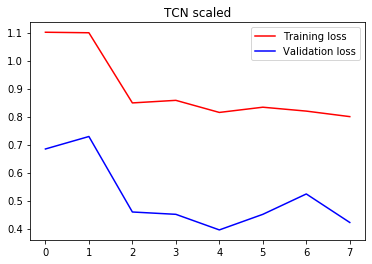

In [37]:
plot_loss(history, 'TCN scaled')

In [38]:
y_predict = model.predict([test_price, test_info]).ravel()
roc_auc_score(test_target, y_predict)

0.880416254229829

In [39]:
y_class = [1 if p > 0.5 else 0 for p in y_predict]
confusion_matrix(test_target, y_class)

array([[43608,  6433],
       [ 4956, 11254]], dtype=int64)

In [40]:
unique, counts = np.unique(y_class, return_counts=True)
dict(zip(unique, counts))

{0: 48564, 1: 17687}

In [41]:
recall_score(test_target, y_class)

0.6942628007402838

In [42]:
precision_recall_fscore_support(test_target, y_class)

(array([0.8979491 , 0.63628654]),
 array([0.87144541, 0.6942628 ]),
 array([0.88449876, 0.66401156]),
 array([50041, 16210], dtype=int64))

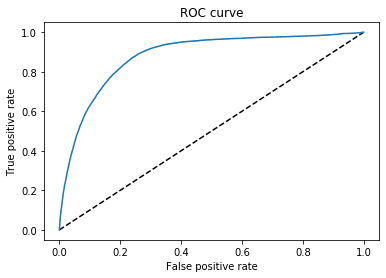

In [43]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_target, y_predict)
auc_keras = auc(fpr_keras, tpr_keras)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [44]:
model.save('pledge_company_model.h5')